# Training CatBoostClassifier Model on Processed Data with CPU, GPU

In [1]:
#import usefull DataStructures
import pandas as pd 
import numpy as np
from scipy.stats import uniform

#import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

#import Misc Libraries
import os
import gc
import pickle
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

#for 100% jupyter notebook cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 100% !important; }</style>"))

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.calibration import CalibratedClassifierCV

#other modelling libraries
from bayes_opt import BayesianOptimization #https://github.com/fmfn/BayesianOptimization, https://machinelearningmastery.com/what-is-bayesian-optimization/
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import XGBRegressor

import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor
from catboost import CatBoostClassifier

In [2]:
#loading saved processed data from part 2
train_data = pickle.load( open( "./data/pre_modelling_train.pkl", "rb" ) )
test_data = pickle.load( open( "./data/pre_modelling_test.pkl", "rb" ) )
target_train = pickle.load( open( "./data/pre_modelling_target_train.pkl", "rb" ) )
skid_test = pickle.load( open( "./data/pre_modelling_skid_test.pkl", "rb" ) )

In [3]:
#standardizing the data
scaler = StandardScaler()
x_train_std = scaler.fit_transform(train_data)
x_test_std = scaler.fit_transform(test_data)
y_train = target_train

#replacing nan values with 0
x_train_std[np.isnan(x_train_std)] = 0
x_test_std[np.isnan(x_test_std)] = 0

In [45]:
class cat_boosting:
    '''
    Class for Boosting Ensembles and displaying results. Contains 6 methods:
    
        1. init method
        2. train method
        3. proba_to_class method
        4. tune_threshold method
        5. results method
        6. feat_importance_show
    '''

    def __init__(self, x_train, y_train, x_test, params, num_folds = 3, random_state = 33, 
                 verbose = True, save_model_to_pickle = False):
        '''
        Function to initialize the class members.
        
        Inputs:
            self
            x_train: DataFrame
                Training DataFrame
            y_train: DataFrame
                Training Class labels
            x_test: DataFrame
                Test DataFrame
            params: dict
                Parameters for the boosting ensemble
            num_folds: int, default = 3
                Number of folds for k-Fold Cross Validation
            random_state: int, default = 33
                Random State for Splitting the data for K-Fold Cross Validation
            verbose: bool, default = True
                Whether to keep verbosity or not
            save_model_to_pickle: bool, default = False
                Whether to save the model to pickle file or not
        
        Returns:
            None
        '''

        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.params = params
        self.num_folds = num_folds
        self.stratified_cv = StratifiedKFold(n_splits = num_folds, shuffle = True, random_state = random_state)
        self.verbose = verbose
        self.save_model = save_model_to_pickle
        
    def train(self, booster, verbose = 400, early_stopping = 200, pickle_name = '', plot_flag = False):
        '''
        Function to train the Classifier on given parameters. It fits the classifier for each fold, and for 
        Cross Validation, uses Out-of-Fold Predictions. The test predictions are averaged predictions over each fold.
        
        Inputs:
            self
            booster: str
                Whether the booster is 'xgboost' or 'lightgbm' or 'catboost'
            verbose: int, default = 400
                Number of boosting rounds for printint boosting results.
            early_stopping: int, default = 200
                Number of boosting rounds to look for early stopping
            pickle_name: str, default = ''
                The string to add to end of pickle file of model, if any
        
        Returns:
            None        
        '''
        
        self.train_preds_proba_mean = np.zeros(self.x_train.shape[0])
        #out-of-fold cv predictions
        self.cv_preds_proba = np.zeros(self.x_train.shape[0])
        self.test_preds_proba_mean = np.zeros(self.x_test.shape[0])
        #best threshold will be 
        self.best_threshold_train = 0
        self.feature_importance = pd.DataFrame()
        self.feature_importance['features'] = self.x_train.columns
        self.feature_importance['gain'] = np.zeros(self.x_train.shape[1])
        
        if self.verbose:
            print(f"Fitting the {booster} on Training Data with {self.num_folds} fold cross validation, and using Out-Of-Folds Predictions for Cross-Validation")
            start = datetime.now()
        
        for fold_number, (train_indices, cv_indices) in enumerate(self.stratified_cv.split(self.x_train, self.y_train), 1):
            if self.verbose:
                print(f"\n\tFold Number {fold_number}\n")
            
            x_tr = self.x_train.iloc[train_indices]
            y_tr = self.y_train.iloc[train_indices]
            x_cv = self.x_train.iloc[cv_indices]
            y_cv = self.y_train.iloc[cv_indices]
            
            if booster == 'xgboost':
                clf = XGBClassifier(**self.params)
            elif booster == 'lightgbm':
                clf = LGBMClassifier(**self.params)
            else: #catboost
                clf = CatBoostClassifier(**self.params)
                    
                
            clf.fit(x_tr, y_tr, eval_set = [(x_tr, y_tr), (x_cv, y_cv)], 
                     verbose = verbose, early_stopping_rounds = 200, plot = plot_flag)
            
            if booster == 'xgboost':
                self.train_preds_proba_mean[train_indices] = clf.predict_proba(x_tr, ntree_limit = clf.get_booster().best_ntree_limit)[:, 1] / (self.num_folds - 1)
                self.cv_preds_proba[cv_indices] = clf.predict_proba(x_cv, ntree_limit = clf.get_booster().best_ntree_limit)[:,1]
                self.test_preds_proba_mean += clf.predict_proba(self.x_test, ntree_limit = clf.get_booster().best_ntree_limit)[:,1] / self.num_folds

                #feature importance
                gain_fold = clf.get_booster().get_score(importance_type = 'gain')
                feat_imp = pd.DataFrame()
                feat_imp['features'] = gain_fold.keys()
                feat_imp['gain'] = gain_fold.values()
            
            elif booster == 'lightgbm': #lightgbm
                self.train_preds_proba_mean[train_indices] = clf.predict_proba(x_tr, num_iteration = clf.best_iteration_)[:,1] / (self.num_folds - 1)
                self.cv_preds_proba[cv_indices] = clf.predict_proba(x_cv, num_iteration = clf.best_iteration_)[:,1]
                self.test_preds_proba_mean += clf.predict_proba(self.x_test, num_iteration = clf.best_iteration_)[:,1] / self.num_folds

                #feature importance
                gain_fold = clf.booster_.feature_importance(importance_type='gain')
                feat_imp = pd.DataFrame()
                feat_imp['features'] = self.x_train.columns
                feat_imp['gain'] = gain_fold
            else: #catboost
                # self.train_preds_proba_mean[train_indices] = clf.predict_proba(x_tr, 
                #                                                                ntree_start = clf.best_iteration_, 
                #                                                                ntree_end = clf.best_iteration_ + 1)[:,1] / (self.num_folds - 1)
                # self.cv_preds_proba[cv_indices] = clf.predict_proba(x_cv, ntree_start = clf.best_iteration_, 
                #                                                                ntree_end = clf.best_iteration_ + 1)[:,1]
                # self.test_preds_proba_mean += clf.predict_proba(self.x_test, ntree_start = clf.best_iteration_, 
                #                                                                ntree_end = clf.best_iteration_ + 1)[:,1] / self.num_folds
                self.train_preds_proba_mean[train_indices] = clf.predict_proba(x_tr)[:,1] / (self.num_folds - 1)
                self.cv_preds_proba[cv_indices] = clf.predict_proba(x_cv)[:,1]
                self.test_preds_proba_mean += clf.predict_proba(self.x_test)[:,1] / self.num_folds
                #feature importance
                gain_fold = clf.feature_importances_
                feat_imp = pd.DataFrame()
                feat_imp['features'] = self.x_train.columns
                feat_imp['gain'] = gain_fold
                
                
            #tuning the threshold for optimal TPR and FPR from ROC Curve
            self.best_threshold_train += self.tune_threshold(self.y_train[train_indices], self.train_preds_proba_mean[train_indices]) / self.num_folds
            #concatenating the feature importance of each fold to original df
            self.feature_importance = pd.concat([self.feature_importance, feat_imp], axis = 0)

            if self.save_model:
                #saving the model into a pickle file
                with open(f'./data/clf_{booster}_fold_{fold_number}_model_{pickle_name}.pkl', 'wb') as f:
                    pickle.dump(clf, f)
          
        #mean feature importance averaged over all folds
        self.feature_importance = self.feature_importance.groupby('features', as_index = False).mean()
        #sorting the feature importance
        self.feature_importance = self.feature_importance.sort_values(by = 'gain', ascending = False)
        
        if self.verbose:
            print("Done.")
            print(f"Time elapsed = {datetime.now() - start}")
        gc.collect()
        
    def proba_to_class(self, proba, threshold):
        '''
        Function to convert a given probability to class label based on a threshold value.
        
        Inputs:
            self
            proba: numpy array
                Probabilities of class label = 1
            threshold: int
                Threshold probability to be considered as Positive or Negative Class Label
            
        Returns:
            Converted Class Label
        '''

        return np.where(proba >= threshold, 1, 0)
        
    def tune_threshold(self, true_labels, predicted_probas):
        '''
        Function to find the optimal threshold for maximizing the TPR and minimizing the FPR from ROC-AUC Curve.
        This is found out by using the J Statistic, which is J = TPR - FPR.
        Reference: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
        
        Inputs:
            self
            true_labels: numpy array or pandas series
                True Class Labels
            predicted_probas: numpy array
                Predicted Probability of Positive Class label
            
        Returns:
            Threshold probability.
        '''

        fpr, tpr, threshold = roc_curve(true_labels, predicted_probas)
        j_stat = tpr - fpr
        index_for_best_threshold = np.argmax(j_stat)
        
        return threshold[index_for_best_threshold]
           
    def results(self, roc_auc = True, precision_recall = True, show_conf_matrix = True, cv_test_distribution = False):
        '''
        Function to display the final results of Train, CV and Test Dataset.
        
        Inputs:
            self
        
        Returns:
            None
        '''
        
        #getting the crisp class labels
        self.train_preds_class = self.proba_to_class(self.train_preds_proba_mean, self.best_threshold_train)
        self.cv_preds_class = self.proba_to_class(self.cv_preds_proba, self.best_threshold_train)
        self.test_preds_class = self.proba_to_class(self.test_preds_proba_mean, self.best_threshold_train)
        print("=" * 100)
        print("Train Results:")
        print(f"\nThe best selected Threshold as per the J-Statistic, which is J = TPR - FPR, is = {self.best_threshold_train}\n")
        if roc_auc:
            print(f"\tROC-AUC Score = {roc_auc_score(self.y_train, self.train_preds_proba_mean)}")
        if precision_recall:
            print(f"\tPrecision Score = {precision_score(self.y_train, self.train_preds_class)}")
            print(f"\tRecall Score = {recall_score(self.y_train, self.train_preds_class)}")
        print("CV Results:")
        if roc_auc:
            print(f"\tROC-AUC Score = {roc_auc_score(self.y_train, self.cv_preds_proba)}")
        if precision_recall:
            print(f"\tPrecision Score = {precision_score(self.y_train, self.cv_preds_class)}")
            print(f"\tRecall Score = {recall_score(self.y_train, self.cv_preds_class)}")

        if show_conf_matrix:
            print('=' * 100)
            print("Confusion, Precision and Recall Matrix on CV data:")
            conf_mat = confusion_matrix(self.y_train, self.cv_preds_class)
            conf_mat = pd.DataFrame(conf_mat, columns = ['Predicted_0','Predicted_1'], index = ['Actual_0','Actual_1'])
            plt.figure(figsize = (7,6))
            plt.title('Confusion Matrix Heatmap')
            sns.heatmap(conf_mat, annot = True, fmt = 'g', linewidth = 0.5, annot_kws = {'size' : 15})
            plt.show()
        
        if cv_test_distribution:
            print('=' * 100)
            print("Distribution of Original Class Labels and Predicted CV and Test Class Labels")
            plt.figure(figsize = (20,6))
            plt.subplot(1,3,1)
            plt.title('Class Distribution of Original Dataset')
            sns.countplot(self.y_train)
            plt.subplot(1,3,2)
            plt.title('Class Distribution of predicted Class Labels on CV')
            sns.countplot(self.cv_preds_class)
            plt.subplot(1,3,3)
            plt.title('Class Distribution of predicted Test Dataset')
            sns.countplot(self.test_preds_class)
            plt.show()
        print('=' * 100)
        
        gc.collect()
    
    def feat_importances_show(self, num_features, figsize = (10,15)):
        '''
        Function to display the top most important features.
        
        Inputs:
            self
            num_features: int
                Number of top features importances to display
            figsize: tuple, default = (10,15)
                Size of figure to be displayed
            
        Returns:
            None
        '''
        
        plt.figure(figsize = figsize) 
        sns.barplot(self.feature_importance['gain'].iloc[:num_features], 
                    self.feature_importance['features'].iloc[:num_features], orient = 'h')
        plt.title(f'Top {num_features} features as per classifier')
        plt.xlabel('Feature Importance')
        plt.ylabel('Feature Names')
        plt.grid()
        plt.show()
        print('=' * 100)
        
        gc.collect()

## Test  CPU

In [31]:
params = {
    'learning_rate' : 0.01,
    'eval_metric': 'AUC',
    'n_estimators' : 1000,
    'max_depth' : 5,
    'min_child_samples' : 80,
    'colsample_bylevel' : 0.5699318202360774,
    'reg_lambda' : 0.03564525547115141,
    'random_state' : 42
} 

In [32]:
    
X_train, X_validation, y_train, y_validation = train_test_split(train_data, target_train, train_size=0.8, random_state=42)

clf = CatBoostClassifier(**params)

clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_validation, y_validation)], 
                 verbose_eval = 50, early_stopping_rounds = 100, plot=True)
    

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6940571	test1: 0.6882441	best: 0.6882441 (0)	total: 204ms	remaining: 3m 23s
50:	test: 0.7584303	test1: 0.7549618	best: 0.7552215 (48)	total: 11s	remaining: 3m 23s
100:	test: 0.7663035	test1: 0.7621045	best: 0.7621177 (98)	total: 21.6s	remaining: 3m 12s
150:	test: 0.7714174	test1: 0.7672110	best: 0.7672110 (150)	total: 32.3s	remaining: 3m 1s
200:	test: 0.7759023	test1: 0.7718879	best: 0.7718879 (200)	total: 42.9s	remaining: 2m 50s
250:	test: 0.7790657	test1: 0.7752858	best: 0.7752858 (250)	total: 54s	remaining: 2m 41s
300:	test: 0.7817454	test1: 0.7779051	best: 0.7779051 (300)	total: 1m 4s	remaining: 2m 30s
350:	test: 0.7836677	test1: 0.7798549	best: 0.7798549 (350)	total: 1m 15s	remaining: 2m 20s
400:	test: 0.7857428	test1: 0.7818167	best: 0.7818167 (400)	total: 1m 26s	remaining: 2m 9s
450:	test: 0.7874039	test1: 0.7832623	best: 0.7832623 (450)	total: 1m 37s	remaining: 1m 59s
500:	test: 0.7888124	test1: 0.7845510	best: 0.7845510 (500)	total: 1m 48s	remaining: 1m 48s
550:	tes

In [33]:
clf.best_iteration_

999

In [34]:
clf.predict_proba(X_validation, ntree_start = clf.best_iteration_, ntree_end = clf.best_iteration_ + 1)

array([[0.50004502, 0.49995498],
       [0.49999731, 0.50000269],
       [0.499619  , 0.500381  ],
       ...,
       [0.49999731, 0.50000269],
       [0.50004502, 0.49995498],
       [0.49999731, 0.50000269]])

In [40]:
a = clf.predict_proba(X_validation)

In [44]:
print(f'min: {min(a[:,0])}')
print(f'max: {max(a[:,0])}')
print(f'min: {min(a[:,1])}')
print(f'max: {max(a[:,1])}')

min: 0.010361315036407581
max: 0.996864928944795
min: 0.0031350710552050074
max: 0.9896386849635924


In [36]:
clf.get_feature_importance().max()

36.92717332660058

In [39]:
clf.feature_importances_

array([0.        , 0.08483556, 0.00587416, ..., 0.        , 0.        ,
       0.        ])

## Boosting method

In [46]:
cb_boosting = cat_boosting(train_data, target_train, test_data, params, random_state = 98, save_model_to_pickle = True)
cb_boosting.train(booster = 'catboost')

Fitting the catboost on Training Data with 3 fold cross validation, and using Out-Of-Folds Predictions for Cross-Validation

	Fold Number 1

0:	test: 0.7024532	test1: 0.7080920	best: 0.7080920 (0)	total: 171ms	remaining: 2m 51s
400:	test: 0.7843553	test1: 0.7862527	best: 0.7862527 (400)	total: 1m 15s	remaining: 1m 52s
800:	test: 0.7950115	test1: 0.7937132	best: 0.7937132 (800)	total: 2m 30s	remaining: 37.5s
999:	test: 0.7985316	test1: 0.7956759	best: 0.7956759 (999)	total: 3m 7s	remaining: 0us

bestTest = 0.7956759314
bestIteration = 999


	Fold Number 2

0:	test: 0.6617842	test1: 0.6594850	best: 0.6594850 (0)	total: 145ms	remaining: 2m 24s
400:	test: 0.7854983	test1: 0.7809740	best: 0.7809740 (400)	total: 1m 13s	remaining: 1m 50s
800:	test: 0.7955595	test1: 0.7895085	best: 0.7895085 (800)	total: 2m 29s	remaining: 37.1s
999:	test: 0.7989058	test1: 0.7918125	best: 0.7918125 (999)	total: 3m 6s	remaining: 0us

bestTest = 0.7918124544
bestIteration = 999


	Fold Number 3

0:	test: 0.654562

In [21]:
# ###with plot
# cb_boosting = cat_boosting(train_data, target_train, test_data, params, random_state = 98, save_model_to_pickle = True)
# cb_boosting.train(booster = 'catboost', plot_flag=True)

Fitting the catboost on Training Data with 3 fold cross validation, and using Out-Of-Folds Predictions for Cross-Validation

	Fold Number 1



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7024532	test1: 0.7080920	best: 0.7080920 (0)	total: 171ms	remaining: 2m 50s
400:	test: 0.7843553	test1: 0.7862527	best: 0.7862527 (400)	total: 1m 16s	remaining: 1m 54s
800:	test: 0.7950115	test1: 0.7937132	best: 0.7937132 (800)	total: 2m 32s	remaining: 37.9s
999:	test: 0.7985316	test1: 0.7956759	best: 0.7956759 (999)	total: 3m 11s	remaining: 0us

bestTest = 0.7956759314
bestIteration = 999


	Fold Number 2



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6617842	test1: 0.6594850	best: 0.6594850 (0)	total: 165ms	remaining: 2m 44s


KeyboardInterrupt: 

Train Results:

The best selected Threshold as per the J-Statistic, which is J = TPR - FPR, is = 0.040586713543595054

	ROC-AUC Score = 0.7991647011566586
	Precision Score = 0.18450191999024768
	Recall Score = 0.7316012084592145
CV Results:
	ROC-AUC Score = 0.7926123874329822
	Precision Score = 0.12782234530743966
	Recall Score = 0.8998590130916415
Confusion, Precision and Recall Matrix on CV data:


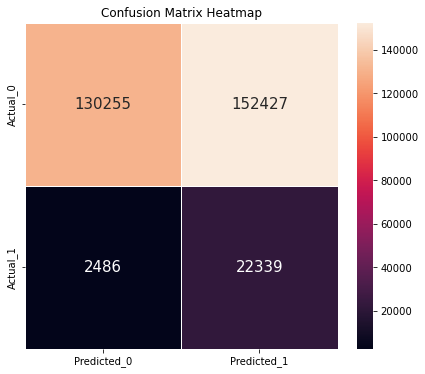

In [47]:
#displaying the results and metrics
cb_boosting.results()

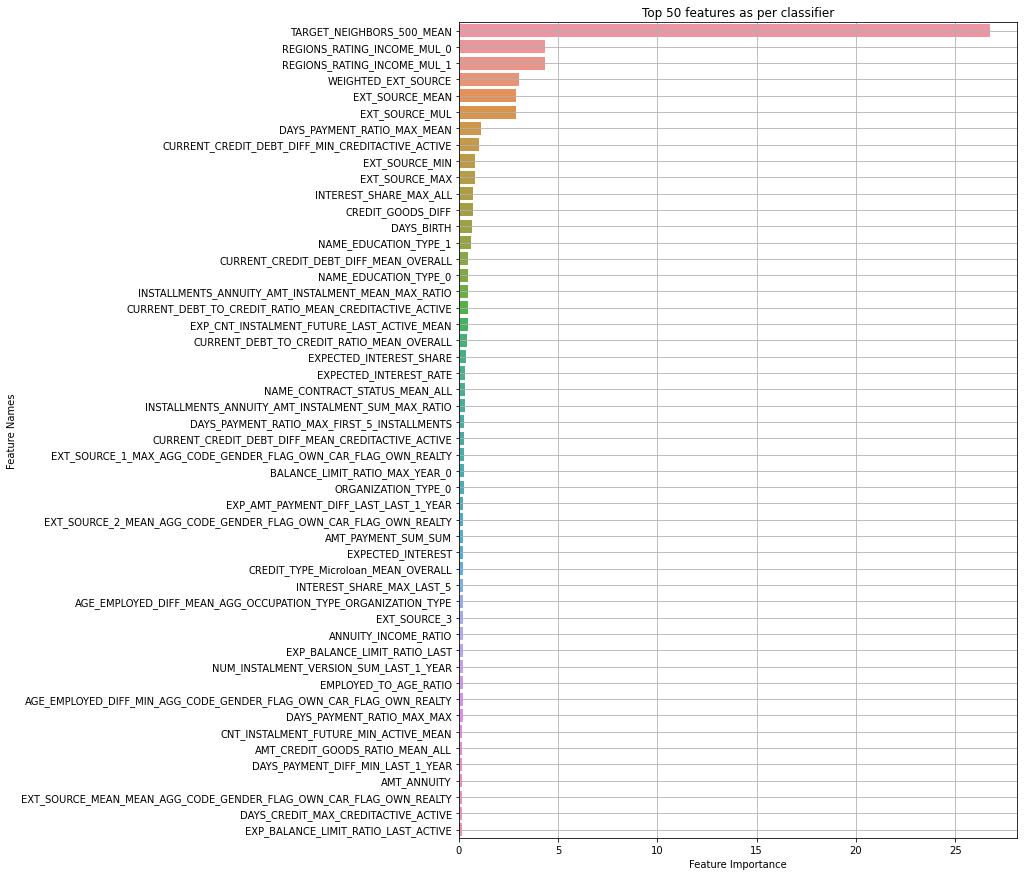

In [48]:
#displaying top 50 important features
cb_boosting.feat_importances_show(50)

## Test GPU

after some search on the internet, I think `"atboost_options.cpp:612: Error: rsm on GPU is supported for pairwise modes only"` is a bug, so stop trying this case on GPU now.

colsample_bylevel=0.57 caused the above error.

In [4]:
params = {
    'task_type': 'GPU',
    'eval_metric': 'AUC',
    'n_estimators' : 10000,
    'learning_rate' : 0.01,
    'max_depth' : 5,
    'min_child_samples' : 80,
    'reg_lambda' : 0.03564525547115141,
    'random_state' : 42
} 


In [5]:
    
X_train, X_validation, y_train, y_validation = train_test_split(train_data, target_train, train_size=0.8, random_state=42)

clf_gpu = CatBoostClassifier(**params)

clf_gpu.fit(X_train, y_train, eval_set=(X_validation, y_validation), 
                 verbose_eval = 200, early_stopping_rounds = 100, plot=True)
    

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7374999	test: 0.7310336	best: 0.7310336 (0)	total: 22.9ms	remaining: 3m 48s
200:	learn: 0.7817160	test: 0.7773573	best: 0.7773573 (200)	total: 4.54s	remaining: 3m 41s
400:	learn: 0.7887157	test: 0.7838696	best: 0.7838696 (400)	total: 9.14s	remaining: 3m 38s
600:	learn: 0.7939117	test: 0.7880740	best: 0.7880766 (599)	total: 13.7s	remaining: 3m 33s
800:	learn: 0.7978543	test: 0.7907870	best: 0.7907870 (800)	total: 18.1s	remaining: 3m 27s
1000:	learn: 0.8009584	test: 0.7926419	best: 0.7926419 (1000)	total: 22.5s	remaining: 3m 22s
1200:	learn: 0.8037207	test: 0.7940794	best: 0.7940794 (1200)	total: 26.8s	remaining: 3m 16s
1400:	learn: 0.8061323	test: 0.7951041	best: 0.7951041 (1400)	total: 31.1s	remaining: 3m 10s
1600:	learn: 0.8084491	test: 0.7959526	best: 0.7959526 (1600)	total: 35.4s	remaining: 3m 5s
1800:	learn: 0.8105833	test: 0.7967362	best: 0.7967362 (1800)	total: 39.6s	remaining: 3m
2000:	learn: 0.8126810	test: 0.7974127	best: 0.7974139 (1999)	total: 44s	remaining: 2m 5

In [ ]:
clf_gpu.predict_proba(test_data)[:,1]

In [6]:
clf_gpu_model_df = pd.DataFrame({'SK_ID_CURR': skid_test, 'TARGET' : clf_gpu.predict_proba(test_data)[:,1]})
clf_gpu_model_df['SK_ID_CURR'] = clf_gpu_model_df['SK_ID_CURR'].astype(int)
clf_gpu_model_df.to_csv('./submissions/catboost_gpu_model.csv',index = False)

|        Model       | Private Score | Public Score |
|--------------------|---------------|--------------|
| CatBoost_GPU_Model |   0.78860     |   0.79378    |

<!-- ![title](images/catboost_gpu_model.png) -->
<img src="./images/catboost_gpu_model.png" >

## Grid search

unssucced: kernel died

In [ ]:
    
X_train, X_validation, y_train, y_validation = train_test_split(train_data, target_train, train_size=0.8, random_state=42)

clf_gpu = CatBoostClassifier(task_type='GPU', eval_metric='AUC', n_estimators=10000, random_state=42)

grid_params = {'n_estimators': [2000, 40000, 6000, 8000, 10000],
            'learning_rate': list(np.arange(0.01, 0.1, 0.01)),
            'max_depth': list(range(15,25)),
            'min_child_samples': list(range(5,80)),
            'reg_lambda': list(np.arange(0.1, 0.31, 0.1))}

grid_search_result = clf_gpu.grid_search(grid_params, X=X_train, y=y_train, plot=True)

# randm = RandomizedSearchCV(estimator=clf_gpu, param_distributions = grid_params, 
#                                cv = 5, n_iter = 10, n_jobs=2, verbose=True)
# randm.fit(train_data, target_train)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

## Hyperparameter tuning on GPU

unssucced: kernel died

In [6]:
def cbc_evaluation(learning_rate, max_depth, min_child_samples, reg_lambda):
    '''
    Objective function for Bayesian Optimization of CatBoost's Hyperparamters. Takes the hyperparameters as input, and
    returns the Cross-Validation AUC as output.
    
    Inputs: Hyperparamters to be tuned.
        learning_rate, max_depth, min_child_samples, reg_lambda
        
    Returns:
        CV ROC-AUC Score
    '''  
    params = {
        'task_type': 'GPU',
        'eval_metric': 'AUC',
        'n_estimators' : 10000,
        'learning_rate' : learning_rate,
        'max_depth' : int(round(max_depth)),
        'min_child_samples' : int(round(min_child_samples)),
        'reg_lambda' : reg_lambda,
        'random_state' : 42
    }
    
    #defining the Cross-Validation Strategry
    stratified_cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 33)
    cv_preds = np.zeros(train_data.shape[0])
    
    #iterating over each fold, training the model, and making Out of Fold Predictions
    for train_indices, cv_indices in stratified_cv.split(train_data, target_train):
        
        x_tr = train_data.iloc[train_indices]
        y_tr = target_train.iloc[train_indices]
        x_cv = train_data.iloc[cv_indices]
        y_cv = target_train.iloc[cv_indices]
        
        cbc = CatBoostClassifier(**params)
        cbc.fit(x_tr, y_tr, eval_set= (x_cv,y_cv), verbose = False, early_stopping_rounds = 200)
        
        cv_preds[cv_indices] = cbc.predict_proba(x_cv)[:,1]
        gc.collect()   
        
    return roc_auc_score(target_train, cv_preds)

In [ ]:
#defining the optimizer and the hyperparameters along with ranges of values.
bopt_cbc =  BayesianOptimization(cbc_evaluation, {
                                                  'learning_rate': (0.01, 0.1),
                                                  'max_depth' : (5,15),
                                                  'min_child_samples' : (5,80),
                                                  'reg_lambda' : (0.001, 0.3)}, 
                                 random_state = 55)

bopt_cbc.maximize(n_iter = 6, init_points = 4) #cost time: 

#the package has bug: kernel died when start tuning

|   iter    |  target   | learni... | max_depth | min_ch... | reg_la... |
-------------------------------------------------------------------------
